# Solar Output Prediction 
### Report Writeup + Technical Analysis

by Evan Baker

## Executive Summary

The goal of this project is to accurately predict how much energy solar panels will produce annually.  The ultimate aim is to build a tool that allows prospective solar customers and solar sales teams to better understand the financial outcomes of installing a solar array.  Currently, the National Renewable Energy Laboratory records data from solar installations from across the US, and gives a prediction for the annual energy those panels will create.  My goal is to build a model that more accurately predicts the potential output of an array.

The models in this report improved R2 from the NREL baseline of .87 to over .95 using a random forest model.  I've also built an online tool for evaluating annual output using this model, available here: %link%

### Data

The first step in this project was gathering and cleaning data related to solar installations, and the cost of producing solar energy for these installations.  I've gathered data from two sources, both run by the National Renewable Energy Lab.  The first is the OpenPV data set, which is manually entered data relating to individual photovoltaic solar installations.  This data includes data such as the size of the installation, it's location, how much it cost to build, how much it costs for it to produce energy, which incentive programs were used to pay for its installation, etc.  The second data set relates to local solar irradiance, including average temperature, wind speed, solar iradiance and peak sun angle for 2015.

The OpenPV data was simply downloaded in CSV format from the NREL website, located here: https://openpv.nrel.gov/search

The OpenPV dataset includes the following values (and more):

 - **date_installed**: Date installed (completion date or interconnection date)
 - **incentive_prog_names**: government incentive program that helped fund the solar installation.
 - **size_kw**: Size/capacity (in kW DC) of solar installation
 - **zipcode**: zipcode of installation:
 - **install_type**: category of type of place solar installation is installed.  Residential, commercial, etc.
 - **cost_per_watt**: cost for every watt of solar energy produced.
 - **cost**: Total installed cost (in USD, before any applicable incentives)
 - **tech_1**: type of solar panels installed, technology behind the solar panel
 - **annual_PV_prod**: how much energy is produced annually in kw
 - **tilt1**: tilt angle of the solar panel.
 - **tracking_type**: how solar panel tracks the sun, can either be fixed or tracking on 1 or 2 axes, or a mix.
 - **azimuth1**: average azimuth (projected angle from north to sun) at solar installation.
 - **reported_annual_energy_prod**: a self reported amount of watts produced, varies from annual_pv_prod, but this is all self reported data so it's likely just a duplicate column
 - **tracking**: whether installation has a moving sun-tracking system.
 - **bipv**: building integrated photovoltaic, basically whether this installation is on the side of a building

### Solar Data

Gathering solar irradiance data from the NREL's national solar radiance database required two weeks, given the API's 1000 query/day limit, and the 14000 unique zipcodes included in the OpenPV dataset.  In order to gather this data I deployed the following script on an AWS EC2 instance.  When the script had finished, I ran a slightly modifed version to collect any zipcodes that had returned a 429 response too many times.  The data was saved locally on the EC2 instance in a SQLite database.



In [ ]:
import time
from datetime import datetime
import random
import pandas as pd
import numpy as np
import sqlite3
import requests

"""
This script will query the NREL API for a list of zip/lat+lon pairs, find the average values for a bunch
of solar related data from that area.  It will return csvs that have saved all of that data.
It should be able to be run on AWS on a 24 chronjob, and automatically pick up from the last
zipcode that was successfully grabbed.
"""

# loading in the csv file that has all the zipcodes with their corresponding lat/lon pairs
good_zips = pd.read_csv("./good_zips_lat_lon.csv")

# making series of the lats, lons, and zipcodes
lats = good_zips["LAT"].values
lons = good_zips["LNG"].values
zips = good_zips["zipcode"].values

# Defining all our API values that we'll use later in the API queries.
api_key = 'XcdWax2Nw6JI5oheYhiipXaeo9uiTObT3XJNYFYt'
attributes = 'ghi,dhi,dni,wind_speed_10m_nwp,surface_air_temperature_nwp,solar_zenith_angle'
year = '2015'
leap_year = 'false'
interval = '60'
utc = 'false'
your_name = 'evan+baker'
reason_for_use = 'beta+testing'
your_affiliation = 'General+Assembly'
your_email = 'evancasebaker@gmail.com'
mailing_list='true'


# Connecting to the database where we'll store failed zipcodes and our last_success zipcode.
conn = sqlite3.connect("./solar_logs.sqlite")

# This will try to find a csv that holds our last successfully found zipcode, if it doesn't
# exist, we'll just set it to 0 and start from the beginning.
starting_zipcode = pd.read_sql("SELECT * FROM last_success", con=conn)["zipcode"][0]
print "starting on: ", starting_zipcode

# This will set our top level for our high level iterator, based on our last success
top_of_loop = starting_zipcode + 2000

# Setting up a placeholder variable, we'll iteratively update this, and then at the end write
# it to our database so we can load it up the next time this script runs.
last_success = pd.read_sql("SELECT * FROM last_success", con=conn)["zipcode"][0]

# creating a failed_zips list that we'll later add to our database.
failed_zips = []

def query_api(fails, last_success):
    """
    This function queries the NREL API, find the average for the current lat lon, year, etc.,
    aggregates all the returned data and appends it to a dictionary defined outside the function.

    parameters:
        fails: defines the number of times the api has returned a 429 response.
                Used to stop the code if API quota has been exhausted/API is not working.
    """
    try:
        url = 'http://developer.nrel.gov/api/solar/nsrdb_0512_download.csv?wkt=POINT({lon}%20{lat})&names={year}&leap_day={leap}&interval={interval}&utc={utc}&full_name={name}&email={email}&affiliation={affiliation}&mailing_list={mailing_list}&reason={reason}&api_key={api}&attributes={attr}'.format(year=year, lat=lat, lon=lon, leap=leap_year, interval=interval, utc=utc, name=your_name, email=your_email, mailing_list=mailing_list, affiliation=your_affiliation, reason=reason_for_use, api=api_key, attr=attributes)
        # Return all but first 2 lines of csv to get data:
        info = pd.read_csv(url, nrows=2)
        df = pd.read_csv(url, skiprows=2)
        # creating a pivot table of our data, so that we get the average values for the whole year.
        pivot = df.pivot_table(["GHI","DHI","DNI","Wind Speed","Temperature","Solar Zenith Angle"], index="Year")
        for c in pivot.columns:
            zipcode_values[c].append(pivot[c].values[0])
        zipcode_values["Zipcode"].append(zips[bottom:top][i])
        print 'going to next zipcode'
        wait_time = random.randint(3,6)
        time.sleep(wait_time)
        # Updating last_success, it should be the top level iteration + lower level iteration.
        last_success = iteration + i
        # reset our successive_fails variable to 0, because we've had a success and want to stop counting them.
        fails = 0
    except:
        url = 'http://developer.nrel.gov/api/solar/nsrdb_0512_download.csv?wkt=POINT({lon}%20{lat})&names={year}&leap_day={leap}&interval={interval}&utc={utc}&full_name={name}&email={email}&affiliation={affiliation}&mailing_list={mailing_list}&reason={reason}&api_key={api}&attributes={attr}'.format(year=year, lat=lat, lon=lon, leap=leap_year, interval=interval, utc=utc, name=your_name, email=your_email, mailing_list=mailing_list, affiliation=your_affiliation, reason=reason_for_use, api=api_key, attr=attributes)
        # Add 1 to our successive_fails variable, which will iterate for every fail on the same zipcode.
        fails += 1
        resp = requests.get(url)
        response_code = resp.status_code
        print response_code
        if response_code == 429 and fails <= 5:
            wait_time = random.randint(6,8)
            time.sleep(wait_time)
            fails, last_success = query_api(fails, last_success)
        else:
            print "zipcode failed, going to next zipcode"
            # add this zipcode to the failed zips list.
            failed_zips.append(iteration + i)
            wait_time = random.randint(3,6)
            time.sleep(wait_time)

    # function spits out updated "successive fails" number and what the last success was
    return fails, last_success

# Setting normal iteration size to 500.  this will only change if the starting zip+2000 is greater than the lengeth of the csv we're drawing from.
iteration_size = 500

# Setting it up so if we're towards the end of the list, it'll just make one final csv.
if top_of_loop > len(zips):
    top_of_loop = len(zips)
    iteration_size = top_of_loop - starting_zipcode

# Setting up a higher level loop that will spit out a csv for every x number of zipcodes
for iteration in range(starting_zipcode, top_of_loop, iteration_size):

    zipcode_values = {
        "Zipcode": [],
        "DHI": [],
        "DNI": [],
        "GHI": [],
        "Solar Zenith Angle": [],
        "Temperature": [],
        "Wind Speed": []
    }

    bottom = int(iteration)
    top = int(iteration) + iteration_size
    # setting our successive_fails variable, used by the query_api function.
    successive_fails = 0

    for i, (lat, lon) in enumerate(zip(lats[bottom:top], lons[bottom:top])):
        print lat, lon, i

        # calling our query_api function, which should take in all the current variables
        # we have set and append data to the zipcode_values dictionary.
        # it should also be able to handle 429 responses.

        #if we get 15 successive 429 responses the query function will stop.
        if successive_fails <= 15:
            successive_fails, last_success = query_api(successive_fails, last_success)
            print "successive fails: ", successive_fails
        else:
            break

    # only export to csv and to the db if there's actually some data.
    if len(zipcode_values['Zipcode']) > 0:
        zipcode_df = pd.DataFrame(zipcode_values)
        # exporting the data as a csv.
        zip_filepath = "./zipcode_data_%s.csv" % str(bottom)
        zipcode_df.to_csv(zip_filepath)
        # add this to our database as well.
        zipcode_df.to_sql("zipcode_data", con=conn, if_exists='append')
        print "exporting csv for iteration range: %s : %s" % (bottom, top)

# change last_success table in db
last_success_df = pd.DataFrame({'zipcode': [last_success]})
last_success_df.to_sql("last_success", con=conn, if_exists='replace')

# adding the failed zips to the failed_zips table in our db
failed_zips_df = pd.DataFrame({'zip_index':failed_zips})
failed_zips_df.to_sql("failed_zips", if_exists='append', con=conn)

print datetime.now().time()


The solar irradiance data includes the following values:
- **DNI**: the amount of solar radiation received per unit area by a surface that is always held perpendicular (or normal) to the rays that come in a straight line from the direction of the sun at its current position in the sky.
- **DHI**: the amount of radiation received per unit area by a surface (not subject to any shade or shadow) that does not arrive on a direct path from the sun, but has been scattered by molecules and particles in the atmosphere and comes equally from all directions.
- **GHI**: the total amount of shortwave radiation received from above by a surface horizontal to the ground, encompassing both DNI and DHI.
- **Temperature**: Average temperature in C
- **Wind Speed**: Average windspeed in miles per hour.
- **Solar Zenith Angle**: Average angle from horizon to sun's peak.


# Data Cleaning

Given that the OpenPV dataset is manually entered, getting the most out of it required a lot of data cleaning and imputation.  For more on what processes I used, go to this notebook: **LINK**

# Exploratory Analysis

It's clear from the below graph that annual energy produced is extremely well correlated with the size of the installation.  This will be by far the most predictive feature in my models.

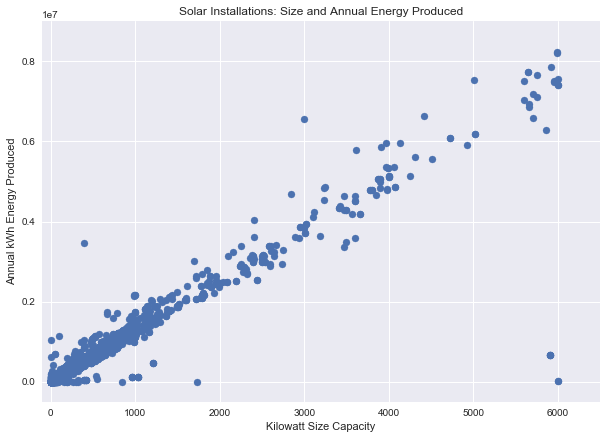

In [131]:
plt.figure(figsize=((10,7)))
plt.scatter(df.size_kw, df.reported_annual_energy_prod)
plt.xlim(-100,6500)
plt.ylim(-500000,.9*10**7)
plt.xlabel("Kilowatt Size Capacity")
plt.ylabel("Annual kWh Energy Produced")
plt.title("Solar Installations: Size and Annual Energy Produced")

It's intersting to compare the NREL 'annual PV prod' and the reported values, given that this is the NREL prediction compared to the actual annual energy produced.  This is where I'm trying to improve in my own modeling.

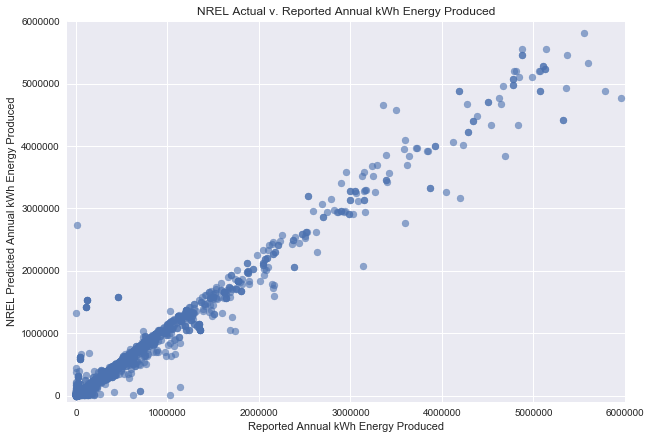

In [133]:
# masking cases where reported and predicted are the same, because in data cleaning I imputed some missing values
# for the NREL predictions using reported data.
mask = df['reported_annual_energy_prod'] != df['annual_PV_prod']

plt.figure(figsize=((10,7)))
plt.scatter(df.loc[mask,'reported_annual_energy_prod'], df.loc[mask,'annual_PV_prod'], alpha=0.6)
plt.xlim(-100000,6000000)
plt.ylim(-100000,6000000)
plt.ylabel("NREL Predicted Annual kWh Energy Produced")
plt.xlabel("Reported Annual kWh Energy Produced")
plt.title("NREL Actual v. Reported Annual kWh Energy Produced")

### Cost per Watt per installation, based on technology type.

I used plotly to make some interesting views of nationwide distribution of solar installations.  Here we look at how much it costs to produce energy for different technology types.  I was curious to know whether different technologies would have an effect on how much energy a solar array produces, as well as how production may vary by region.

**Plot**: https://plot.ly/~ebaker12/28/cost-per-watt-per-installation-by-technology-click-legend-to-toggle-traces/

In [134]:
# Code for the above plot is below

In [ ]:
# sampling the larger dataset so that plot can render.
df_small = df.sample(10000)

# reading in a csv of zipcode/lat/lon data, because lat/lon is required for geographic plotting in plotly.
lat_lon = pd.read_csv("./free-zipcode-database-Primary.csv")

# merging in lat lon data
df_small = df_small.merge(lat_lon, left_on="zipcode", right_on="Zipcode")

df_small.tech_1.unique().tolist()

tech_types = df.tech_1.unique().tolist()

colors = ["white", "rgb(0,116,217)","rgb(255,65,54)","rgb(133,20,75)","rgb(255,133,27)",
         'green', 'yellow', 'pink', 'black', 'lightgrey', 'teal', 'maroon']
categories = []
scale = 200

for i in range(len(tech_types)):
    df_sub = df_small.loc[df_small['tech_1'] == tech_types[i], :]
    cat = dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lat = df_sub['Lat'],
        lon = df_sub['Long'],
        text = df_sub['cost_per_watt'],
        marker = dict(
            size = (1/df_sub['cost_per_watt']**2) * scale,
            color = colors[i],
            line = dict(width=0.5, color='rgb(40,40,40)'),
            sizemode = 'area'
        ),
        name = str(tech_types[i]))
    categories.append(cat)

layout = dict(
        title = 'Cost Per Watt per Installation By Technology<br>(Click legend to toggle traces)',
        showlegend = True,
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )

fig = dict( data=categories, layout=layout )
py.iplot(fig, validate=False, filename='installation_cost_per_watt_by_tech' )

There's a lot of interesting takeaways from looking at the data this way.

1.  Installations are highly concentrated in California and New England.  This clear geographical division indicates that there are localized factorized that play into the decision to build solar, such as local incentive programs, taxes and rebates.  Those will be important to take into account when predicting cost per watt later on.
2.  There's no clear relationship between technology type and cost per watt, indicating that there may not be clear standouts in terms of the productivity of different solar technologies.
3.  It looks as if there's cheaper energy production in southern than northern california, indicating that irradiance is likely a factor in determining cost of production.

## Correlations between Irradiance Data and Output Efficiency

Looking at the correlations of irradiance data with efficiency shows a clear trend that more irradiance and heat correlates with higher efficiency.  It's also noteworthy that there's a lot of correlation between these features, which means we'll want to only include a few to avoid multicolinearity in our modelling.

In [139]:
def correlation_heat_map(df, title, size):
    """DOCSTRING
    This function plots a correlation heatmap for a dataframe, masking duplicate values.
    """
    corrs = df.corr()
    
    # set figure size
    fig, ax = plt.subplots(figsize = size)
    
    # generate a mask for the upper triagle 
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    #plot heatmap
    ax = sns.heatmap(corrs, mask=mask, annot = True, cbar=False)
    
    #resize labels
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=12, rotation=30)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=12, rotation=0)
    ax.set_title(title, fontsize=14)
    
    plt.show()

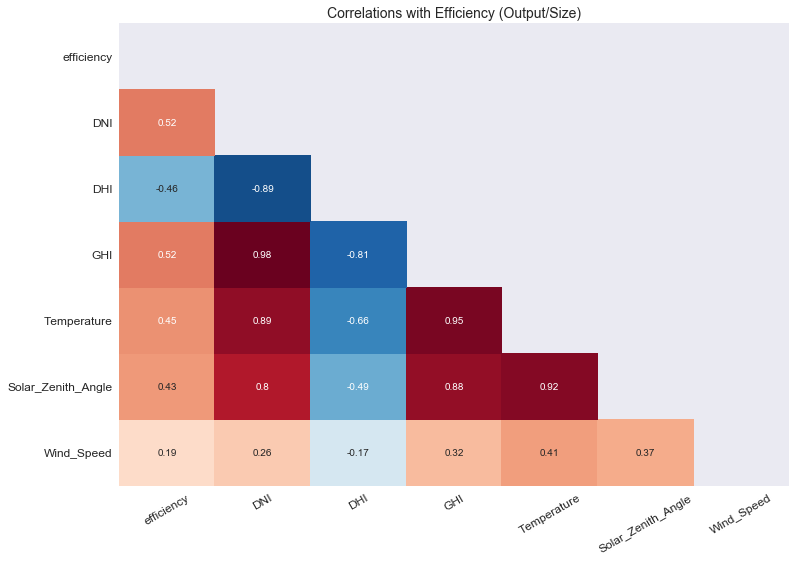

In [140]:
# looking at the correlation with a new "efficiency" column, because I want to control for the size of the installation.
df['efficiency'] = df['reported_annual_energy_prod'] / df['size_kw']

correlation_heat_map(df[['efficiency', "DNI", "DHI", "GHI", "Temperature", 'Solar_Zenith_Angle', 'Wind_Speed']],
                     "Correlations with Efficiency (Output/Size)", (12,8.5))


# Outliers

There are some values for reported annual energy that are way too high, and I want to remove those from the data to improve predictive accuracy.

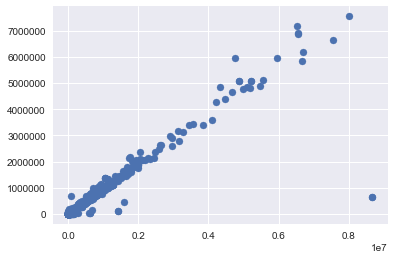

In [252]:
plt.scatter(nrel_y_pred, nrel_y_true)

In [263]:
# Given how connected size and annual energy production is, I'm going to remove any data from the data set where
# efficiency is more than 6 standard deviations from the mean.  Picking a number so high just to be cautious.

# It looks like there must be some installations where efficiency is MUCH higher than the rest.
df['efficiency'] = df['reported_annual_energy_prod'] / df['size_kw']

efficiency_std = df.efficiency.std()
efficiency_mean = df.efficiency.mean()

efficiency_mask = np.abs((efficiency_mean - df['efficiency'])/efficiency_std) < 6

df = df.loc[efficiency_mask, :]

# Modeling

My final models include an Elastic Net, Random Forest Regression, and a simple feed forward neural network.  Given how linearly related size and annual energy output is, a linear model like elastic net seems like an obvious choice.  I was quickly and easily able to implement this model, and it beat out the NREL predictions.  It also has very intuitive results.  I was able to improve on my R2 score from the elastic net model using a random forest model, however implementation and parameter tuning takes much longer.  The elastic net took around 30 minutes to find the optimal parameters, whereas the random forest took around 5 hours.  Tuning the neural network is not as easily done with a grid search, so it's not as trivial to say how long parameter tuning takes, but also on the order of hours as opposed to minutes.  These results are obviously not easily interpretable either.

### Features

Based on my exploratory analysis, I settled on the following features for my model:
- Kilowatt Size/Capacity 
- Azimuth
- Tilt
- Technology type
- Tracking type
- Diffuse Horizontal Irradiance (DHI)
- Direct Normal Irradiance (DNI)
- Wind Speed

These features are strong predictors of annual output, and are easily obtained for use in a production environment model.



In [1]:
import pandas as pd
import numpy as np
import sqlite3

from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

import patsy

In [2]:
# Reading in the data from csvs
df_open = pd.read_csv("./data/open_pv_clean.csv")
df_zips = pd.read_csv("./data/nrel_solar_data.csv")

# merging two datasets on zipcode
df = df_open.merge(df_zips, right_on = 'Zipcode', left_on = 'zipcode')

# dropping unnecessary rows
del(df['city'])
del(df['manufacturer'])
del(df['inv_man_clean'])
del(df['model1_clean'])
del(df['sales_tax_cost'])
del(df['annual_insolation'])
del(df['lbnl_tts'])
del(df['county'])
del(df['date_installed'])
del(df['cost_per_watt'])

# Weird extra columns
del(df['Unnamed: 0_x'])
del(df['Unnamed: 0_y'])

# imputing data for tilt and azimuth.  Picking the median to avoid biasing the model.
median_tilt = df.tilt1.median()
median_azimuth = df.azimuth1.median()

df.tilt1.fillna(median_tilt, inplace=True)
df.azimuth1.fillna(median_azimuth, inplace=True)

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (10,12,13,16,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# removing outliers

df['efficiency'] = df['reported_annual_energy_prod'] / df['size_kw']

efficiency_std = df.efficiency.std()
efficiency_mean = df.efficiency.mean()

efficiency_mask = np.abs((efficiency_mean - df['efficiency'])/efficiency_std) < 6

df = df.loc[efficiency_mask, :]

# Feature Engineering: Adding Difference From Optimal Tilt

Optimal tilt during the winter is about latitude + 15, and during the winter it's about latitude - 15, so we can approximate optimal tilt using latitude.  To get the amount that the tilt of an array is off from the optimal, we take the absolute value of the difference between the tilt and its latitude.

In [4]:
# rading in a csv that has lat/lon pairs for zipcodes.
zips = pd.read_csv("./free-zipcode-database-Primary.csv")

# joining latitude with main dataframe.
df = df.merge(zips[['Zipcode', 'Lat']], on="Zipcode")

# Calculating optimal tilt difference as absolute value of difference between the tilt and latitude.
df['optimal_tilt_diff'] = np.abs(df['tilt1'] - df['Lat'])

### Building Design Matrices + train/test split

I used patsy to build my design matrices.  Patsy automatically one hot encodes categorical features like technology and tracking type, and splits our data into X and y dataframes.

In all my models, I'm using a random state of 25 when splitting data into training and testing sets, so that I can completely objectively score each model against one another after training

In [5]:
formula = """\
reported_annual_energy_prod ~ size_kw + azimuth1 + optimal_tilt_diff + tech_1 + DHI + DNI + Wind_Speed + tracking_type"""

print 'splitting into X and y design matrices'
y, X = patsy.dmatrices(formula, df, return_type='dataframe')

scaler = StandardScaler()

X_scaled = pd.DataFrame(scaler.fit_transform(X))

# not using this, just doing a built in evaluation split.
print 'splitting into train and test'

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=.75, random_state=25)

splitting into X and y design matrices
splitting into train and test


## Calculating Baseline R2

We'll use NREL's annual energy output compared to reported to calculate a baseline r2 score.

In [ ]:
from sklearn.metrics import r2_score

In [26]:
X_test_index = X_test.index.values.tolist()

In [27]:
# getting nrel reported and predicted annual pv produced

nrel_y_true = [val[0] for val in y_test.copy().values]
nrel_y_pred = df.ix[X_test_index, 'annual_PV_prod'].values.tolist()

### Baseline Score

In [69]:
from sklearn.metrics import r2_score

In [70]:
r2_score(nrel_y_true, nrel_y_pred)

0.91504295425123838

In [71]:
mse_nrel = mean_squared_error(nrel_y_true, nrel_y_pred)

# Root mean squared error dollars
mse_nrel ** 0.5 * .1024

4701.3345001996277

In [72]:
# Calculating median dollars estimate is off in annual returns on solar energy generated.

abs_residuals = np.abs(np.array(nrel_y_true) - np.array(nrel_y_pred))

# avg us rate per kilowatt hour is $.1024
residuals_dollars = abs_residuals * .1024

np.median(residuals_dollars)

61.262380031999946

## Training a Linear Regression with size_kw alone

Given the importance of size, let's see what kind of score we can get by just doing a linear regression with size.

In [6]:
from sklearn.linear_model import LinearRegression

In [7]:
lin_reg = LinearRegression()

In [8]:
size_kw_index = None

for i, c in enumerate(X.columns):
    if c == "size_kw":
        size_kw_index = i

size_kw_index

15

In [9]:
# Getting training data into correct shape to fit the model.
size_kw_train = np.array(X_train.loc[:, size_kw_index].values).reshape((len(X_train),1))

lin_reg.fit(size_kw_train, np.array(y_train).ravel())

//anaconda/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [10]:
# Getting testing data into correct shape to fit the model.
size_kw_test = np.array(X_test.loc[:, size_kw_index].values).reshape((len(X_test),1))
lin_reg.score(size_kw_test, np.array(y_test).ravel())

0.92907346868194052

In [12]:
from sklearn.metrics import mean_squared_error

In [13]:
# What does this improvement mean in dollars annually?

lr_pred = lin_reg.predict(size_kw_test)
mse_lr = mean_squared_error(np.array(y_test), lr_pred)

# Root mean squared error dollars
mse_lr ** 0.5 * .1024

4295.6195659638724

In [21]:
lr_residuals_abs = np.abs(np.array(y_test.values).ravel() - lr_pred)
# median absolute value error in dollars

np.median(lr_residuals_abs * .1024)

150.06259129211793

## Training Elastic Net Model

In [99]:
# creating a gridsearch to find optimal elastic net parameters.

params = {
    'alpha': np.linspace(0.08,.15,5),
}
en = ElasticNet(.95)
gs_en = GridSearchCV(en, params, cv=8, verbose=1)

In [100]:
gs_en.fit(X_train, y_train)

Fitting 8 folds for each of 5 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   35.6s finished


GridSearchCV(cv=8, error_score='raise',
       estimator=ElasticNet(alpha=0.95, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([ 0.08  ,  0.0975,  0.115 ,  0.1325,  0.15  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [102]:
gs_en.best_score_

0.92139789975183162

In [104]:
gs_en.best_params_

{'alpha': 0.080000000000000002}

In [103]:
gs_en.score(X_test, y_test)

0.90262400157114253

In [105]:
# expanding gridsearch, since optimal alpha was the lowest possible value from previous grid search parameters.

params = {
    'alpha': np.linspace(0.01,.08,8),
    'l1_ratio': np.linspace(.8,1,4)
}
en = ElasticNet()
gs_en = GridSearchCV(en, params, cv=8, verbose=1)

gs_en.fit(X_train, y_train)

Fitting 8 folds for each of 32 candidates, totalling 256 fits


[Parallel(n_jobs=1)]: Done 256 out of 256 | elapsed: 27.9min finished


GridSearchCV(cv=8, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([ 0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08]), 'l1_ratio': array([ 0.8    ,  0.86667,  0.93333,  1.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [106]:
gs_en.best_params_

{'alpha': 0.080000000000000002, 'l1_ratio': 0.80000000000000004}

In [108]:
gs_en.best_score_

0.92184461143995367

In [282]:
gs_en.score(X_test, y_test)

# Our score is not getting better on the testing data.

0.91049939610329389

In [22]:
en = ElasticNet(alpha=.08, l1_ratio=0.8)
en.fit(X_train, y_train)

ElasticNet(alpha=0.08, copy_X=True, fit_intercept=True, l1_ratio=0.8,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [172]:
# saving the model.

en_filename = 'finalized_en_model.sav'
pickle.dump(en, open(en_filename, 'wb'))

### Score for Elastic Net Model

In [23]:
en.score(X_test, y_test)

0.9293679750648387

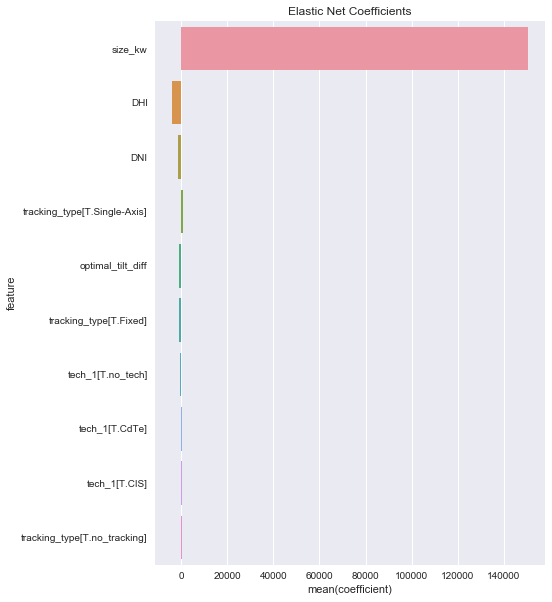

In [60]:
# plotting elastic net coefficients.

coefs = pd.DataFrame({
    'feature': X.columns,
    'coefficient': en.coef_,
    'abs_coef': np.abs(en.coef_)
})
coefs.sort_values('abs_coef', inplace=True, ascending=False)

plt.figure(figsize=(7,10))
sns.barplot(x=coefs.coefficient.head(10), y=coefs.feature.head(10), orient='h')
plt.title("Elastic Net Coefficients")

In [ ]:
# What does this improvement mean in dollars annually?

In [28]:
en_pred = en.predict(X_test)
mse_en = mean_squared_error(np.array(nrel_y_true), en_pred)

# Root mean squared error dollars
mse_en ** 0.5 * .1024

4286.6919944469637

In [29]:
en_residuals_abs = np.abs(np.array(nrel_y_true) - en_pred)
# median absolute value error in dollars

np.median(en_residuals_abs * .1024)

158.6822585401917

# Training Random Forest Model

In [113]:
rand_forest = RandomForestRegressor(n_estimators=150)

params = {
    'max_depth': [65,70,75,80,90],
    'max_features': [10,11,12]
}

gs_rf = GridSearchCV(rand_forest, params, cv=8, verbose=1)

In [31]:
# making a new train/test split that's not normalized.

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=25)

In [116]:
gs_rf.fit(X_train, y_train)

Fitting 8 folds for each of 15 candidates, totalling 120 fits


//anaconda/lib/python2.7/site-packages/sklearn/model_selection/_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 194.6min finished
//anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  best_estimator.fit(X, y, **self.fit_params)


GridSearchCV(cv=8, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [10, 11, 12], 'max_depth': [65, 70, 75, 80, 90]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [117]:
gs_rf.best_score_

0.91866230060217668

In [118]:
gs_rf.score(X_test, y_test)

0.9487661780415132

In [119]:
gs_rf.best_params_

{'max_depth': 65, 'max_features': 11}

In [ ]:
# Let's try some different params, since max depth was the lowest level we gave it.

In [120]:
params = {
    'max_depth': [60,62,65],
    'max_features': [10,11,12]
}

gs_rf = GridSearchCV(rand_forest, params, cv=8, verbose=1)

In [121]:
gs_rf.fit(X_train, y_train)

Fitting 8 folds for each of 9 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 120.9min finished


GridSearchCV(cv=8, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [10, 11, 12], 'max_depth': [60, 62, 65]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [122]:
gs_rf.best_params_

{'max_depth': 62, 'max_features': 12}

In [123]:
gs_rf.best_score_

0.91995480462950152

### Score for RF model:

In [32]:
rf = RandomForestRegressor(n_estimators=150, max_depth=62, max_features=12)

%time rf.fit(X_train, y_train)

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


CPU times: user 2min 4s, sys: 2.31 s, total: 2min 6s
Wall time: 2min 11s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=62,
           max_features=12, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [34]:
rf.score(X_test, y_test)

0.97305201121015517

In [ ]:
# saving this model.
import pickle

filename = 'finalized_rf_model.sav'
pickle.dump(rf, open(filename, 'wb'))

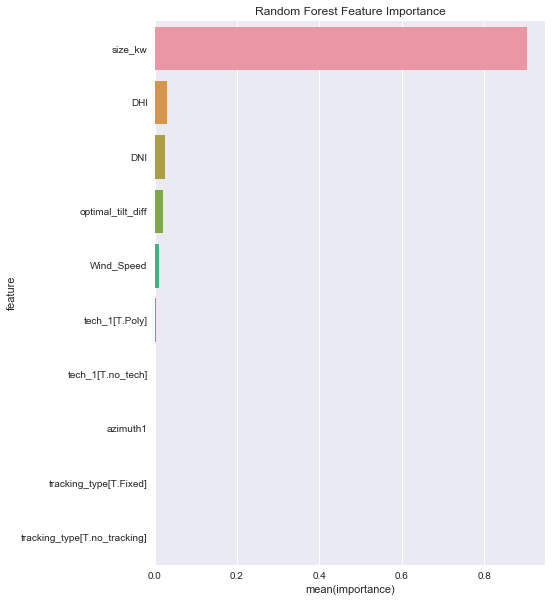

In [37]:
feature_imports = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
})

feature_imports.sort_values("importance", inplace=True, ascending=False)
plt.figure(figsize=(7,10))
sns.barplot(x=feature_imports.importance.head(10), y=feature_imports.feature.head(10), orient='h')
plt.title("Random Forest Feature Importance")

In [38]:
rf_pred = rf.predict(X_test)

In [39]:
mse_rf = mean_squared_error(nrel_y_true, rf_pred)

# Root mean squared error dollars
mse_rf ** 0.5 * .1024

2647.7966620365455

In [40]:
# Calculating median dollars estimate is off in annual returns on solar energy generated.

abs_residuals = np.abs(np.array(nrel_y_true) - np.array(rf_pred))

# avg us rate per kilowatt hour is $.1024
residuals_dollars = abs_residuals * .1024

np.median(residuals_dollars)

15.446016000000016

# Neural Net Model

This neural net model scored a .925 R2 on the testing data, failing to outperform the random forest model.  After extensive tuning I was unable to get the R2 over this amount.  Given the time required to train and tune this model, it's lack of interpretability, and the strength of the models I've already built, I decided to move on from this, and use the random forest model in production for my web app.

In [165]:
import keras
import keras.backend as K
#K._BACKEND == 'tensorflow'

import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import Callback

import patsy
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


//anaconda/lib/python2.7/site-packages/dask/dataframe/hashing.py:6: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import is_bool_array


AttributeError: 'module' object has no attribute 'computation'

In [ ]:
# this is a custom r2 function to use in the model for evaluating performance
def custom_r2(y_true, y_pred):
    baseline = K.sum((y_true - K.mean(y_true))**2)
    model_fit = K.sum((y_true - y_pred)**2)
    return 1. - model_fit/baseline

In [ ]:
# Building Neural Net Model:
model = Sequential()

model.add(Dense(1024, input_shape=(21,), kernel_initializer='normal'))
model.add(Activation('elu'))
model.add(Dropout(.2))

model.add(Dense(1024, kernel_initializer='normal'))
model.add(Activation('elu'))
model.add(Dropout(.5))

model.add(Dense(1, kernel_initializer='normal'))
model.add(Activation('linear'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=[custom_r2])

In [ ]:
def early_stopping_cont_nn(model, X, y, val_data, batch_size=1, verbose=1, epochs_per_iter=1, max_iterations=10,
                           patience=3, min_delta=.1):
    """DOCSTRING:
    This function takes a keras neural net model predicting a continuous variable, with a custom r2 function as
    the evaluation metric.  It will check the change to the r2 value and do an early stop if the r2 does not change by
    the amount specifed in min delta.

    - model: keras model to fit.
    - X: numpy array of X training data.
    - y: numpy array of y training data.
    - val_data: (tuple) of numpy arrays of X and y validation data.
    - batch_size: batch size for keras model fitting.
    - verbose: 0/1 for whether keras model fitting is verbose.
    - epochs_per_iteration: (int) How many epochs to fit before checking to see if the evaluation metric has change\
                enough to continue
    - max_iterations: (int) How many iterations through the specified epochs before automatically stopping fitting.
    - patience: (int) How many iterations can have less than the specified delta to the evaluation metric before stopping.
    - min_delta: (int/float) How much evaluation metric must change by at minimum not to raise patience level.
    """

    # if our model doesn't improve by a certain amount for 'patience' times, we'll break the fitting.
    current_patience = 0
    last_r2 = 0

    for i in range(max_iterations):
        model.fit(x=X, y=y, validation_data = val_data, batch_size=batch_size, verbose=verbose, epochs=epochs_per_iter)

        current_r2 = r2_score(y_test, model.predict(np.array(X_test)))
        print "current r2: ", current_r2
        print "-----------------------"
        r2_diff = current_r2 - last_r2

        print "R2 improvement: ", r2_diff
        print "-----------------------"
        if r2_diff < min_delta:
            print "Improvement Does Not Meet Minimum, Adding One to Patience Score"
            print "-----------------------"
            current_patience += 1
        if current_patience >= patience:
            print "Stopping training, patience threshold met"
            break
        last_r2 = current_r2

print 'Training model!'

# Calling the function we just wrote.  May need to tune batch size, min_delta, as well as the model.
early_stopping_cont_nn(model, X=np.array(X_train), y=np.array(y_train).ravel(),
                       val_data=(np.array(X_test), np.array(y_test).ravel()), epochs_per_iter=1,
                       batch_size=500, verbose=1, max_iterations=1000, min_delta=.0005, patience=2)

print r2_score(y_test, model.predict(np.array(X_test)))

model.save('./neural_net_models/nn_2_wide.h5')

# Predicting Output/Size

Given that size domiantes the models so heavily, I wanted to look more closely into what other factors are most heavily influential over output.  I did this by predicting efficiency, as a ratio of output per unit size.  The results are consistent with the other models, but show more clearly that DNI and DHI, or irradiance, is the next most important factor in determing annual energy produced.

In [41]:
from sklearn.preprocessing import MinMaxScaler

formula = """\
efficiency ~ azimuth1 + optimal_tilt_diff + tech_1 + DHI + DNI + Wind_Speed + tracking_type"""

print 'splitting into X and y design matrices'
y, X = patsy.dmatrices(formula, df, return_type='dataframe')

scaler = MinMaxScaler()

X_scaled = X.copy()

for c in X.columns:
    if "[" not in c:
        X_scaled[c] = scaler.fit_transform(X[c].values)

# not using this, just doing a built in evaluation split.
print 'splitting into train and test'

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=.75, random_state=25)

splitting into X and y design matrices
splitting into train and test


//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.re

In [32]:
# expanding gridsearch, since optimal alpha was the lowest possible value from previous grid search parameters.

params = {
    'alpha': np.linspace(0.1,1,11),
    'l1_ratio': np.linspace(.5,1,6)
}
en = ElasticNet()
gs_en = GridSearchCV(en, params, cv=8, verbose=1)

gs_en.fit(X_train, y_train)

Fitting 8 folds for each of 66 candidates, totalling 528 fits


[Parallel(n_jobs=1)]: Done 528 out of 528 | elapsed:  2.4min finished


GridSearchCV(cv=8, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([ 0.1 ,  0.19,  0.28,  0.37,  0.46,  0.55,  0.64,  0.73,  0.82,
        0.91,  1.  ]), 'l1_ratio': array([ 0.5,  0.6,  0.7,  0.8,  0.9,  1. ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [ ]:
gs_en.score(X_test, y_test)

In [33]:
en_efficiency = ElasticNet(alpha=gs_en.best_params_['alpha'], l1_ratio=1)
en_efficiency.fit(X_scaled, y)

ElasticNet(alpha=0.10000000000000001, copy_X=True, fit_intercept=True,
      l1_ratio=1, max_iter=1000, normalize=False, positive=False,
      precompute=False, random_state=None, selection='cyclic', tol=0.0001,
      warm_start=False)

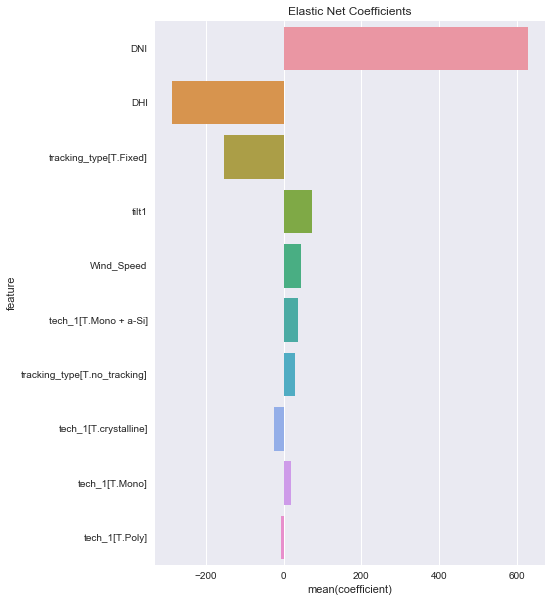

In [34]:
# plotting elastic net coefficients.

coefs = pd.DataFrame({
    'feature': X.columns,
    'coefficient': en_efficiency.coef_,
    'abs_coef': np.abs(en_efficiency.coef_)
})
coefs.sort_values('abs_coef', inplace=True, ascending=False)

plt.figure(figsize=(7,10))
sns.barplot(x=coefs.coefficient.head(10), y=coefs.feature.head(10), orient='h')
plt.title("Elastic Net Coefficients")

# Partial Correlation of DNI with Output

Given that size is such a strong predictor, it's interesting to see what the partial correlation between irradiance and output is.  I chose to look at the partial correlation between DNI and Output.

Surprisingly, we see a pretty much negligble correlation of -0.013.  It's also surprising that this is negative, given that in the elastic net regression the cooefficient for DNI was positive.

In [ ]:
# we need to regress all the variables with DNI and Output and then correlate the residuals.

In [5]:
# First we need to make new dataframes for thre regressions with no DNI

formula = "reported_annual_energy_prod ~ size_kw + azimuth1 + tilt1 + tech_1 + DHI + Wind_Speed + tracking_type"

print 'splitting into X and y design matrices'
y, X = patsy.dmatrices(formula, df, return_type='dataframe')

scaler = StandardScaler()

X_scaled = pd.DataFrame(scaler.fit_transform(X))

# not using this, just doing a built in evaluation split.
print 'splitting into train and test'

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=.75, random_state=25)

splitting into X and y design matrices
splitting into train and test


In [6]:
# just going to use the same parameters from the earlier elastic net model
en_pc_1 = ElasticNet(alpha=.08, l1_ratio=0.8)

In [7]:
en_pc_1.fit(X_train, y_train)

ElasticNet(alpha=0.08, copy_X=True, fit_intercept=True, l1_ratio=0.8,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [8]:
en_pc_1.score(X_test, y_test)

0.92935728635807624

In [13]:
y_test_vals = np.array([val[0] for val in y_test.values])

array([ 13153.64781254,   8096.20823422,   4819.98939862, ...,
         6548.46648003,  16124.46566739,  12426.46498605])

In [16]:
pc_1_residuals = y_test_vals - en_pc_1.predict(X_test)

In [ ]:
# Now we need residuals of all the variables regressed against DNI

In [17]:
formula = "DNI ~ size_kw + azimuth1 + tilt1 + tech_1 + DHI + Wind_Speed + tracking_type"

print 'splitting into X and y design matrices'
y, X = patsy.dmatrices(formula, df, return_type='dataframe')

scaler = StandardScaler()

X_scaled = pd.DataFrame(scaler.fit_transform(X))

# not using this, just doing a built in evaluation split.
print 'splitting into train and test'

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=.75, random_state=25)

splitting into X and y design matrices
splitting into train and test


In [19]:
# just going to use the same parameters from the earlier elastic net model
en_pc_2 = ElasticNet(alpha=.08, l1_ratio=0.8)

In [20]:
en_pc_2.fit(X_train, y_train)

ElasticNet(alpha=0.08, copy_X=True, fit_intercept=True, l1_ratio=0.8,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [21]:
en_pc_2.score(X_test, y_test)

0.82137588088174662

In [22]:
y_test_vals_2 = np.array([val[0] for val in y_test.values])

pc_2_residuals = y_test_vals_2 - en_pc_2.predict(X_test)

In [23]:
from scipy.stats import pearsonr

In [24]:
pearsonr(pc_1_residuals, pc_2_residuals)

(-0.013302328599936315, 0.002747875584863003)

In [ ]:
# Let's look at all the partial correlations

In [80]:
import numpy as np
from scipy import stats, linalg

# Taken from github
def partial_corr(C):
    """
    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
    for the remaining variables in C.
    Parameters
    ----------
    C : array-like, shape (n, p)
        Array with the different variables. Each column of C is taken as a variable
    Returns
    -------
    P : array-like, shape (p, p)
        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
        for the remaining variables in C.
    """
    
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]

            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
        
    return P_corr

In [121]:
partial_corrs_df = df[['size_kw', 'azimuth1', 'tilt1', 'DHI', 'DNI', 'Wind_Speed', 'reported_annual_energy_prod']]

In [86]:
partial_data = np.array(partial_corrs_df)

In [88]:
partial_corrs = partial_corr(partial_data)

In [112]:
def partial_corr_heat_map(df, title, size):
    partial_data = np.array(df)
    corrs = partial_corr(partial_data)
    
    # set figure size
    fig, ax = plt.subplots(figsize = size)
    
    # generate a mask for the upper triagle 
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    #plot heatmap
    ax = sns.heatmap(corrs, mask=mask, annot = True, cbar=False)
    
    #resize labels
    ax.set_xticklabels(df.columns, fontsize=12, rotation=30)
    ax.set_yticklabels(df.columns[::-1], fontsize=12, rotation=0)
    ax.set_title(title, fontsize=14)
    
    plt.show()

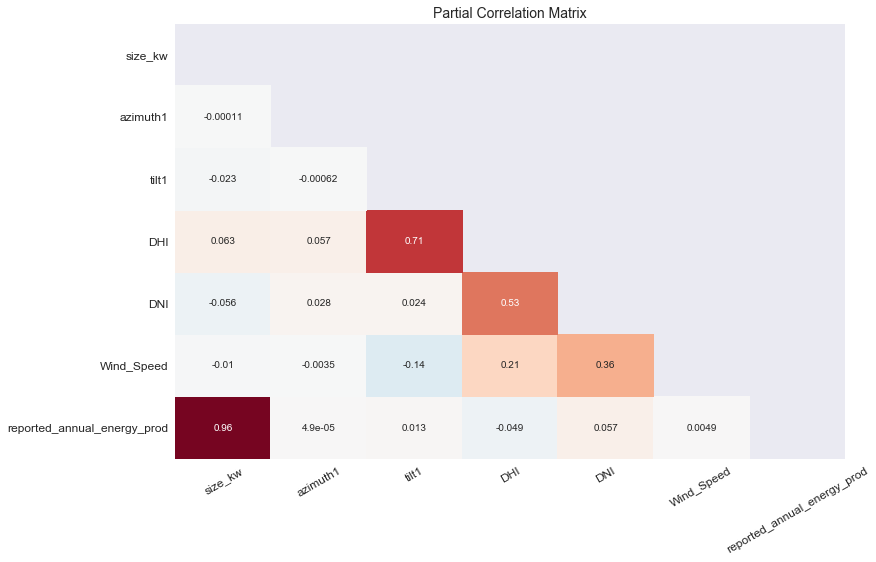

In [122]:
partial_corr_heat_map(partial_corrs_df, "Partial Correlation Matrix", (12,8))

# Legacy Code

### Regressing Against Output Without Size

Want to see how well we can predict output without using size, and get a better idea of the affect of some of the features that are so heavily outweighed by size in other models.

In [71]:
# from sklearn.preprocessing import MinMaxScaler

In [72]:
# formula = "reported_annual_energy_prod ~ azimuth1 + tilt1 + tech_1 + DHI + DNI + Wind_Speed + tracking_type"

# print 'splitting into X and y design matrices'
# y, X = patsy.dmatrices(formula, df, return_type='dataframe')

# scaler = MinMaxScaler()

# X_scaled = X.copy()

# for c in X.columns:
#     if "[" not in c:
#         X_scaled[c] = scaler.fit_transform(X[c].values)

# # not using this, just doing a built in evaluation split.
# print 'splitting into train and test'

# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=.75, random_state=25)

splitting into X and y design matrices
splitting into train and test


//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.re

In [73]:
# # Well that did incredibly badly.
# lasso_cv = LassoCV()
# lasso_cv.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [74]:
# lasso_cv.score(X_test, y_test)

0.0031269992983831152

In [75]:
# lasso = Lasso(alpha=lasso_cv.alpha_)
# lasso.fit(X_train, y_train)

Lasso(alpha=1.478029412624295, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

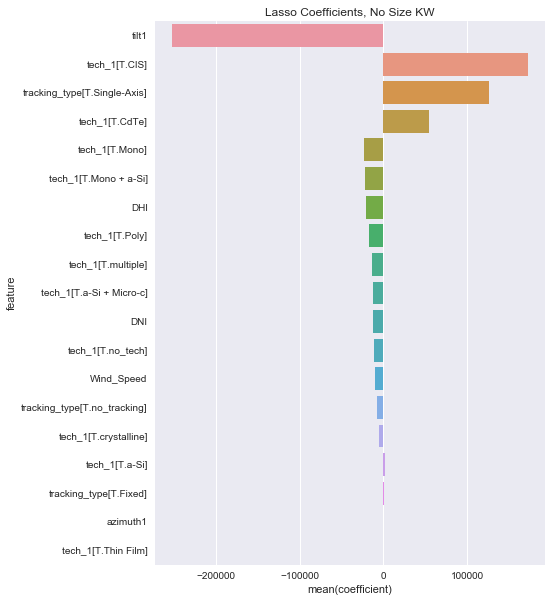

In [76]:
# # plotting Lasso coefficients, in standard deviation scale.


# coefs = pd.DataFrame({
#     'feature': X.columns,
#     'coefficient': lasso.coef_,
#     'abs_coef': np.abs(lasso.coef_)
# })

# coefs.sort_values('abs_coef', inplace=True, ascending=False)

# plt.figure(figsize=(7,10))
# sns.barplot(x=coefs.coefficient.head(19), y=coefs.feature.head(19), orient='h')
# plt.title("Lasso Coefficients, No Size KW")

In [77]:
# lasso.score(X_test, y_test)

0.0031269992983831152

### Outlier stuff

In [27]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# %matplotlib inline

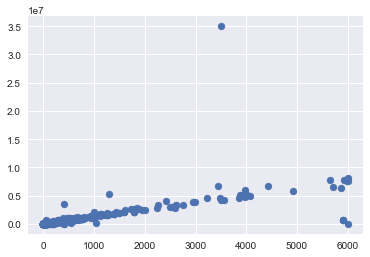

In [28]:
# There's a huge outlier here.

# plt.scatter(X_test.size_kw, y_test)

In [31]:
# y_test.sort_values('reported_annual_energy_prod', ascending=False)

,reported_annual_energy_prod
436695,3.500000e+07
442040,8.205000e+06
431983,7.847000e+06
426115,7.735000e+06
445163,7.551000e+06
425685,7.518734e+06
442762,6.743125e+06
772975,6.632955e+06
461770,6.578451e+06
452292,6.290689e+06


In [29]:
# y.columns

Index([u'reported_annual_energy_prod'], dtype='object')

In [30]:
# type(y_test)

pandas.core.frame.DataFrame

In [36]:
# df.loc[df['reported_annual_energy_prod'] > 1*10**7]

,state,incentive_prog_names,type,size_kw,appraised,zipcode,install_type,installer,cost,utility_clean,...,third_party,bipv,year_installed,DHI,DNI,GHI,Solar_Zenith_Angle,Temperature,Wind_Speed,Zipcode
145973,AZ,Arizona Public Service,uir,18000.0,0.0,86321,residential,SolarCity,7.369182e+07,Arizona Public Service,...,0.0,0.0,2011.0,55.154909,301.173402,232.856963,89.715297,19.075935,2.602529,86321
436695,MA,Massachusetts Department of Energy Resources,uir,3493.6,0.0,1331,commercial,Epcse Solar Corp,1.256500e+07,National Grid,...,0.0,0.0,2013.0,63.192123,198.892580,169.642123,89.682661,8.675551,0.895853,1331


In [37]:
# df.iloc[145973, :]

state                                              AZ
incentive_prog_names           Arizona Public Service
type                                              uir
size_kw                                         18000
appraised                                           0
zipcode                                         86321
install_type                              residential
installer                                   SolarCity
cost                                      7.36918e+07
utility_clean                  Arizona Public Service
tech_1                                        no_tech
annual_PV_prod                            3.06305e+07
rebate                                              0
tilt1                                              22
tracking_type                             no_tracking
azimuth1                                          180
reported_annual_energy_prod                   2.7e+07
new_constr                                          0
tracking                    

In [43]:
# # I'm going to eliminate these rows as outliers, they're overreporting how much energy they're producing.

# df.loc[df['reported_annual_energy_prod'] - df['annual_PV_prod'] < 2*10**6]

,state,incentive_prog_names,type,size_kw,appraised,zipcode,install_type,installer,cost,utility_clean,...,third_party,bipv,year_installed,DHI,DNI,GHI,Solar_Zenith_Angle,Temperature,Wind_Speed,Zipcode
414240,MA,Massachusetts Clean Energy Center,uir,3580.720,0.0,2093,nonprofit,Florence Electric,7.855127e+06,National Grid,...,1.0,0.0,2013.0,64.018607,195.797945,169.773174,89.684537,10.425683,0.882835,2093
433871,MA,Massachusetts Department of Energy Resources,uir,1287.000,0.0,1844,commercial,Borrego Solar,4.697551e+06,National Grid,...,0.0,0.0,2013.0,61.994521,202.102740,170.576027,89.682099,9.814643,0.889159,1844
434192,MA,Massachusetts Clean Energy Center,uir,1287.000,0.0,1844,commercial,Borrego Solar,4.697551e+06,National Grid,...,0.0,0.0,2013.0,61.994521,202.102740,170.576027,89.682099,9.814643,0.889159,1844
436695,MA,Massachusetts Department of Energy Resources,uir,3493.600,0.0,1331,commercial,Epcse Solar Corp,1.256500e+07,National Grid,...,0.0,0.0,2013.0,63.192123,198.892580,169.642123,89.682661,8.675551,0.895853,1331
442762,MA,Massachusetts Department of Energy Resources,uir,3443.365,0.0,1462,residential,"IESI, Inc",1.410869e+07,Unitil,...,1.0,0.0,2014.0,62.824087,200.198288,169.991781,89.682671,9.049544,0.895853,1462
620816,CA,Imperial Irrigation District,uir,400.000,0.0,92231,residential,SolarCity,1.651601e+06,Imperial Irrigation District,...,0.0,0.0,2011.0,52.784132,317.561187,245.184247,89.723793,23.820224,2.524194,92231
621181,CA,Imperial Irrigation District,uir,400.000,0.0,92243,residential,SolarCity,1.651601e+06,Imperial Irrigation District,...,0.0,0.0,2011.0,53.166438,315.838356,243.658676,89.723408,23.632665,2.656314,92243
621417,CA,Imperial Irrigation District,uir,400.000,0.0,92253,residential,SolarCity,1.651601e+06,Imperial Irrigation District,...,0.0,0.0,2011.0,53.451826,311.637900,241.055023,89.719246,20.921113,2.838593,92253
